## Example usage for a Keras Model

Import relevant libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import sklearn.gaussian_process as gp
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Activation

from random_search import RandomSearchOptimizer
from bayesian_optimizer import BayesianOptimizer
from genetic_optimizer import GeneticOptimizer
from optimizer_base import Parameter
from models import KerasModel


Using TensorFlow backend.


Specify the model according to the Keras Model class.

In [2]:
class NNModel(KerasModel):
    def __init__(self, input_dim, hidden_dim, train_epochs=100, batch_size=32): 
        self.epochs = train_epochs
        self.batch_size = batch_size
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.model = Sequential()
        self.model.add(Dense(units=int(hidden_dim), input_dim=input_dim))
        self.model.add(Activation('relu'))
        self.model.add(Dense(units=1))
        self.model.add(Activation('sigmoid'))
        self.model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

    def get_params(self, deep=False):
        return {'batch_size': self.batch_size, 
                'hidden_dim': self.hidden_dim, 
                'input_dim': self.input_dim, 
                'train_epochs': self.epochs}    


In [3]:
# build some artificial data for classification
data, target = make_classification(n_samples=100,
                                   n_features=45,
                                   n_informative=15,
                                   n_redundant=5,
                                   class_sep=1,
                                   n_clusters_per_class=4,
                                   flip_y=0.4)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33, random_state=42)

# define three different classifiers
rf = RandomForestClassifier(max_depth=3, n_estimators=10, min_samples_split=4)
svm = SVC(C=1, kernel='rbf', degree=3)
nn_model = NNModel(input_dim=data.shape[1], hidden_dim=10, train_epochs=100, batch_size=32)

# define the list of hyperparameters to tune for each classifier
rf_params = [Parameter(name='min_samples_split', param_type='integer', lower=2, upper=6),
             Parameter(name='min_weight_fraction_leaf', param_type='continuous', lower=0, upper=0.5)]
svm_params = [Parameter(name='C', param_type='continuous', lower=0.1, upper=5),
              Parameter(name='degree', param_type='integer', lower=1, upper=5)]
nn_params = [Parameter(name='hidden_dim', param_type='integer', lower=10, upper=200)]

model = rf
params = rf_params
# define the score function
def clf_score(y_true,y_pred):
    return np.sum(y_true==y_pred)/float(len(y_true))

rand_search = RandomSearchOptimizer(model=model,
                                    eval_func=clf_score,
                                    hyperparams=params,
                                    grid_size=10)

kernel = gp.kernels.Matern()        
bayesOpt = BayesianOptimizer(model=model, 
                             hyperparams=params, 
                             kernel=kernel,                                  
                             eval_func=clf_score)
n_init_samples = 4    
mutation_noise = {'C': 0.4, 'degree': 0.4, 
                  'min_samples_split':0, 'min_weight_fraction_leaf':0,
                  'hidden_dim': 1}
geneticOpt = GeneticOptimizer(model, params, clf_score, n_init_samples, 
                             'RouletteWheel', mutation_noise)

# train and evaluate the models on the training data; alternatively we could score different sets
# of hyperparameters on validation data 
rand_best_params, rand_best_model = rand_search.fit(X_train=X_train, y_train=y_train, n_iters=50)
bayes_best_params, bayes_best_model = bayesOpt.fit(X_train=X_train, y_train=y_train, n_iters=50)
genetic_best_params, genetic_best_model = geneticOpt.fit(X_train=X_train, y_train=y_train, n_iters=50, n_tries=20)


/Users/johannes/anaconda/envs/trading/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.79295566e-05]), 'nit': 6, 'funcalls': 58}
  " state: %s" % convergence_dict)


Random Search on test data: 0.969696969697
Bayesian Optimisation on test data: 0.969696969697
Genetic Algo on test data: 0.878787878788


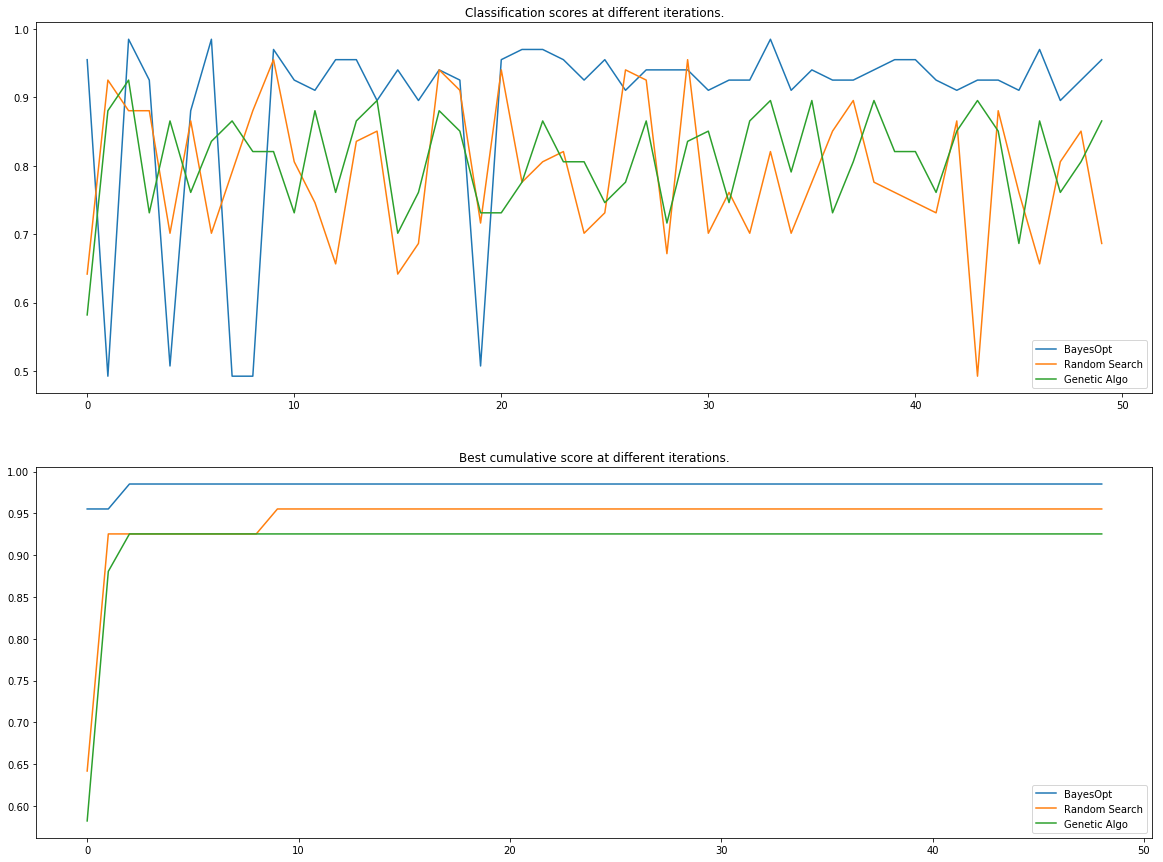

In [34]:
rand_best_model.fit(X_test, y_test)
print("Random Search on test data: {}".format(clf_score(y_test, rand_best_model.predict(X_test))))

bayes_best_model.fit(X_test, y_test)
print("Bayesian Optimisation on test data: {}".format(clf_score(y_test, bayes_best_model.predict(X_test))))

genetic_best_model.fit(X_test, y_test)
print("Genetic Algo on test data: {}".format(clf_score(y_test, genetic_best_model.predict(X_test))))

fig1,axarr = plt.subplots(2,1,figsize=(20,15))
# plot the classification scores per iteration to track improvements
axarr[0].plot([v[0] for v in bayesOpt.hyperparam_history], label='BayesOpt')
axarr[0].plot([v[0] for v in rand_search.hyperparam_history], label='Random Search')
axarr[0].plot([v[0] for v in geneticOpt.hyperparam_history], label='Genetic Algo')    
axarr[0].legend()
axarr[0].set_title("Classification scores at different iterations.")

# plot the improvements of the scores
axarr[1].plot([np.max(np.array(bayesOpt.hyperparam_history)[:i,0]) for i in range(1,len(bayesOpt.hyperparam_history))], label='BayesOpt')
axarr[1].plot([np.max(np.array(rand_search.hyperparam_history)[:i,0]) for i in range(1, len(rand_search.hyperparam_history))], label='Random Search')
axarr[1].plot([np.max(np.array(geneticOpt.hyperparam_history)[:i,0]) for i in range(1,len(geneticOpt.hyperparam_history))], label='Genetic Algo')    
axarr[1].legend()
axarr[1].set_title("Best cumulative score at different iterations.")
plt.show()